In [134]:
#libraries
%matplotlib inline
import pandas as pd
import numpy as np
import scikitplot.plotters as skplt
import nltk
import os
import gensim

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

/Users/fengxiao/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
local_path = '/Users/fengxiao/Documents/Johns Hopkins MS Data Science/2017 Fall/Udacity Machine learning/machine-learning/Machine-Learning-projects/PersonalMedicine'
train_text = pd.read_csv(local_path + '/data/training_text',sep='\|\|',header= None, skiprows=1, names=["ID","TEXT"])




/Users/fengxiao/anaconda/envs/snakes/lib/python3.6/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [3]:
test_text = pd.read_csv(local_path +'/data/test_text',sep='\|\|',header= None, skiprows=1, names=["ID","TEXT"])

/Users/fengxiao/anaconda/envs/snakes/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [5]:
train_var = pd.read_csv(local_path + '/data/training_variants',sep=',')

In [6]:
test_var = pd.read_csv(local_path + '/data/test_variants',sep=',')

## Merge variants and test variables

In [7]:
train = pd.merge(train_var, train_text, how='left', on='ID')

In [8]:
del train_var, train_text
train.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
test= pd.merge(test_var, test_text, how= 'left', on ='ID')
del test_var, test_text
test.head()

,ID,Gene,Variation,TEXT
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [10]:
train.describe(include ='all')

,ID,Gene,Variation,Class,TEXT
count,3321.000000,3321,3321,3321.000000,3321
unique,NaN,264,2996,NaN,1921
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


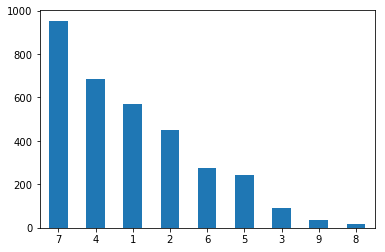

In [11]:
# class checking
train.Class.value_counts().plot(kind='bar',rot=0)

### build a helper to evaluate effecitivness of tranformed features
returns - Log loss, accuracy and confusion matrix 

variables 
- X, feature array
- y, response array
- clf, classifer to use, default logistic regression

In [85]:

def evaluate_feature(X, y, clf=None):
    if clf is None:
        clf= LogisticRegression()
    prob = cross_val_predict(clf,X, y, cv= StratifiedKFold(random_state=8),n_jobs=-1,method='predict_proba',verbose=2)
    pred_indices = np.argmax(prob, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, prob)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)


## Method 1: Bag of words

In [35]:
count_vectorizer = CountVectorizer(analyzer = 'word', tokenizer=nltk.word_tokenize,preprocessor = None, stop_words='english', max_features= None )

In [38]:
#nltk.download('punkt') download 'punkt' if it is not available the first time
bag_of_words = count_vectorizer.fit_transform(train['TEXT'])

[nltk_data] Downloading package punkt to /Users/fengxiao/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [43]:
len(count_vectorizer.get_feature_names())

281586

In [79]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

#### After decomposition 3321 unique words in corpus

In [48]:
len(truncated_bag_of_words)

3321

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
/Users/fengxiao/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 2.256071903936639
Accuracy: 0.314965371875941


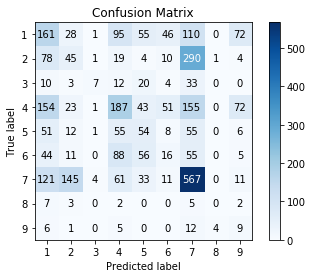

In [86]:
evaluate_feature(truncated_bag_of_words, train['Class'].values.ravel())

### Results are  not desirable 

## Approach 2 - TFIDF

In [88]:
count_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=nltk.word_tokenize, preprocessor= None, stop_words='english', max_features=None)
tfidf = count_vectorizer.fit_transform(train['TEXT'])

In [89]:
tfidf.shape

(3321, 281586)

In [91]:
truncated_tfidf = svd.fit_transform(tfidf)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
/Users/fengxiao/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.6911721879741048
Accuracy: 0.3748870822041554


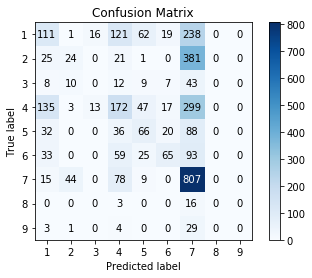

In [93]:
evaluate_feature(truncated_tfidf, train['Class'].values.ravel())

### result better than bag of word, but still bad. it is tend to assign most samples to class7

## Approach 3 word2vec

### First, let's build some helper class 

In [95]:
# MySentences is a generator to produce a list of tokenized sentences
# Takes a list of numpy arrays containing documents
# Args: list of arrays, where each element in the array contains a document

class MySentences(object):
    def __init__(self,*arrays):
        self.arrays=arrays
    
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)
                    
def get_word2vec(sentences, location):
        # returns trained word2vec
        # Args: sentences: iterator for sentences
        # location (str): path to save/load word2vec
    
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
        
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size =100, window=5, min_count=5, workers=4)
    print ('Model done training. Saving to disk')
    model.save(location)
    return model
    
                    

## Training word2vec model

Since word2vec training is unsupervised, using both trainning and test datasets

if training has already been done, the function will just load the word2vec to disk 

In [108]:
word2vec = get_word2vec( MySentences(train['TEXT'].values,test['TEXT'].values),local_path + '/w2model')

/Users/fengxiao/Documents/Johns Hopkins MS Data Science/2017 Fall/Udacity Machine learning/machine-learning/Machine-Learning-projects/PersonalMedicine/w2model not found. training model
Model done training. Saving to disk


### Define a transformer (with sklearn inerface) to convert a document into its corresponding vector

In [125]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X=[]
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.wv.syn0[0])
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv] or [np.zeros(self.dim)], axis=0) 
            for words in X])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [126]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(word2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(train['TEXT'])

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
/Users/fengxiao/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.5675552413781664
Accuracy: 0.4438422161999398


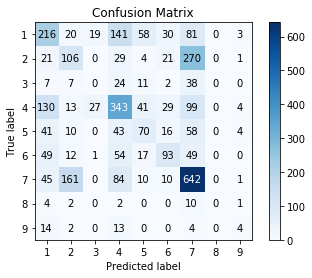

In [129]:
evaluate_feature(mean_embedded, train['Class'].values.ravel())

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s finished
/Users/fengxiao/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.9531228755693342
Accuracy: 0.43179765130984643


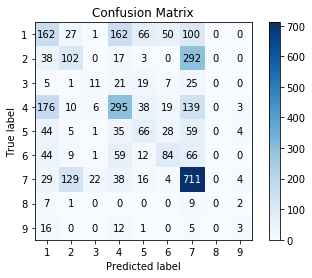

In [132]:
# use Random forest classifier for efficiency validation
evaluate_feature(mean_embedded, train['Class'].values.ravel(), RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished
/Users/fengxiao/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 2.2245663575975585
Accuracy: 0.40861186389641674


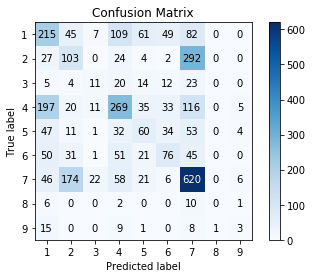

In [135]:
# use XGboost for efficiency evaluation
evaluate_feature(mean_embedded, train['Class'].values.ravel(), XGBClassifier(max_depth=4, objective='multi:softprob', learning_rate=0.33333))

## best result is from Word2Vec with logistic regression